### Data Rundown

#### train.csv
store_nbr: store identifier  
family: type of product sold  
sales: total sales for a family at a store on a date  
onpromotion: number of items in that family on sale  

#### test.csv
test data. To predict target sales. For 15 days after train.csv ends


#### stores.csv
store metadata. contains city, state, type and cluster. Cluster is a grouping of similar stores


#### oil.csv
Daily oil price, for dates in test and train timeframe.


#### holidays_events.csv
Holiday dates. Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer.


### Further Notes:
Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [60]:
holidays_events = pd.read_csv('holidays_events.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
oil_df = pd.read_csv('oil.csv')
sample_df = pd.read_csv('sample_submission.csv')
stores_df = pd.read_csv('stores.csv')
transactions_df = pd.read_csv('transactions.csv')

oil_df['date'] = pd.to_datetime(oil_df['date'])


## Plan, Step 1
There are many variables to explore, given we are forcasting for a future date, we explore time first. We have 4 years worth of data and 54 unique stores. This is too much, so we group the stores based on the info in stores_df and then plot the sales over time.

In [51]:
selected_stores_df = stores_df[['store_nbr', 'cluster']]

train_df_withclusters = pd.merge(train_df, selected_stores_df, on='store_nbr', how='left')

summed_df = train_df_withclusters.groupby(['cluster', 'date']).sum().reset_index()

In [52]:
summed_df['date'] = pd.to_datetime(summed_df['date'])


In [61]:
oil_df

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [53]:
summed_df[summed_df['sales']==0]

,cluster,date,id,store_nbr,family,sales,onpromotion
1684,2,2013-01-01,72930,2607,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,0.0,0
2048,2,2014-01-01,42883698,2607,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,0.0,0
2412,2,2015-01-01,85694466,2607,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,0.0,0
2776,2,2016-01-01,128505234,2607,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,0.0,0
3141,2,2017-01-01,171433614,2607,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,0.0,0
...,...,...,...,...,...,...,...
26944,17,2013-01-01,50622,1683,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,0.0,0
27308,17,2014-01-01,21456006,1683,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,0.0,0
27672,17,2015-01-01,42861390,1683,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,0.0,0
28036,17,2016-01-01,64266774,1683,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,0.0,0


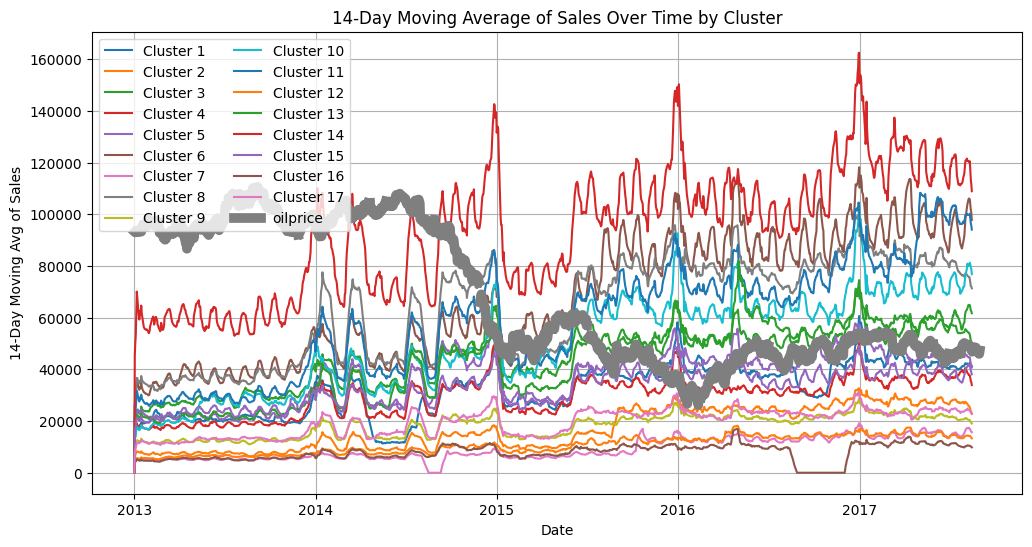

In [67]:
summed_df['sales_rolling_14d'] = (
    summed_df.groupby('cluster')['sales']
    .transform(lambda x: x.rolling(window=14, min_periods=1).mean())
)

plt.figure(figsize=(12, 6))
for cluster, group in summed_df.groupby('cluster'):
    plt.plot(group['date'], group['sales_rolling_14d'], label=f'Cluster {cluster}')

plt.plot(oil_df['date'],oil_df['dcoilwtico']*1000,linewidth=7.0,label='oilprice')

plt.xlabel('Date')
plt.ylabel('14-Day Moving Avg of Sales')
plt.title('14-Day Moving Average of Sales Over Time by Cluster')
plt.legend(loc='upper left', ncol=2)
plt.grid(True)

plt.show()


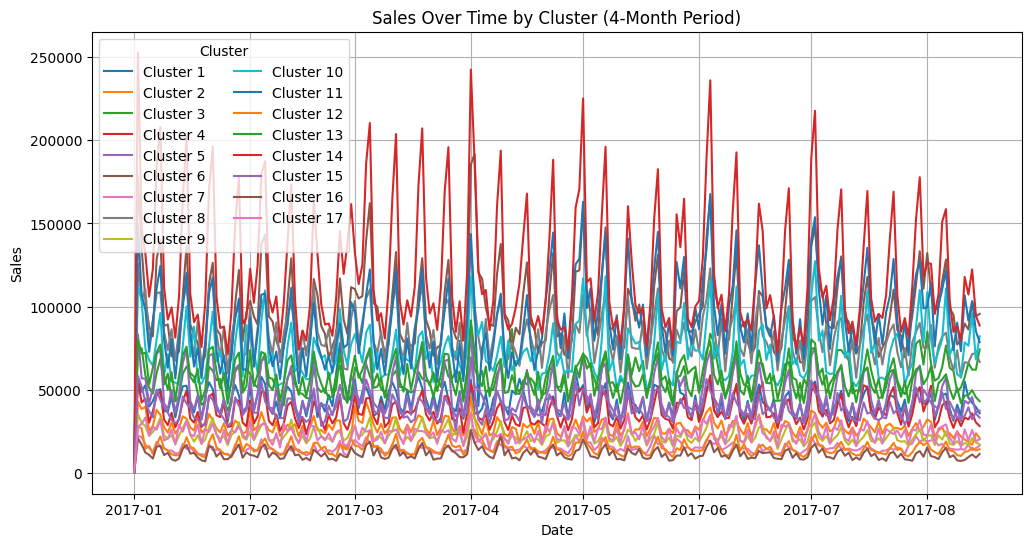

In [69]:
# Filter for a specific 4-month period
filtered_df = summed_df[(summed_df['date'] >= '2017-01-01') & (summed_df['date'] <= '2017-08-30')]

# Plot sales for the filtered time period
plt.figure(figsize=(12, 6))
for cluster, group in filtered_df.groupby('cluster'):
    plt.plot(group['date'], group['sales'], label=f'Cluster {cluster}')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time by Cluster (4-Month Period)')
plt.legend(title='Cluster', loc='upper left', ncol=2)
plt.grid(True)

# Show the plot
plt.show()


In [20]:
train_df[(train_df['store_nbr'] == 1) & (train_df['sales'] > 0)]


,id,date,store_nbr,family,sales,onpromotion
1782,1782,2013-01-02,1,AUTOMOTIVE,2.000000,0
1784,1784,2013-01-02,1,BEAUTY,2.000000,0
1785,1785,2013-01-02,1,BEVERAGES,1091.000000,0
1787,1787,2013-01-02,1,BREAD/BAKERY,470.652000,0
1789,1789,2013-01-02,1,CLEANING,1060.000000,0
...,...,...,...,...,...,...
2999133,2999133,2017-08-15,1,PLAYERS AND ELECTRONICS,21.000000,1
2999134,2999134,2017-08-15,1,POULTRY,234.892000,0
2999135,2999135,2017-08-15,1,PREPARED FOODS,42.822998,0
2999136,2999136,2017-08-15,1,PRODUCE,2240.230000,7


In [25]:
train_df.groupby('store_nbr')['sales'].sum().reset_index().sort_values(by='sales',ascending=False)

,store_nbr,sales
43,44,6.208755e+07
44,45,5.449801e+07
46,47,5.094831e+07
2,3,5.048191e+07
48,49,4.342010e+07
45,46,4.189606e+07
47,48,3.593313e+07
50,51,3.291149e+07
7,8,3.049429e+07
49,50,2.865302e+07


In [19]:
tdf = transactions_df.groupby('store_nbr')['transactions'].sum().reset_index()

In [21]:
tdf

,store_nbr,transactions
0,1,2553963
1,2,3219901
2,3,5366350
3,4,2519007
4,5,2347877
5,6,3065896
6,7,2995993
7,8,4637971
8,9,3516162
9,10,1652493


In [22]:
tdf.sort_values(by = 'transactions', ascending=False)

,store_nbr,transactions
43,44,7273093
46,47,6535810
44,45,6201115
45,46,5990113
2,3,5366350
47,48,5107785
7,8,4637971
48,49,4574103
49,50,4384444
10,11,3972488
